In [1]:
import json
import os
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage
import tifffile
import yaml

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [6]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/submission_v1'

In [8]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

## define inputs

###### HT413C1-Th1k4A1

In [9]:
case = 'HT413C1-Th1k4A1'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]

dtype_to_weight = {
    'he': 1.,
    'multiplex': 1.,
    'xenium': 1.,
    'cosmx': 0. # cosmx just kinda sucks
}

metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s0_HT413C1-Th1k4A1-U14_he.tif'}],
   'position': 0,
   'sid': 'HT413C1-Th1k4A1-U14'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s1_HT413C1-Th1k4A1-U18_he.tif'}],
   'position': 20,
   'sid': 'HT413C1-Th1k4A1-U18'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s2_HT413C1-Th1k4A1-U19_xenium.h5ad'}],
   'position': 25,
   'sid': 'HT413C1-Th1k4A1-U19'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s3_HT413C1-Th1k4A1-U20_multiplex.ome.tiff'}],
   'position': 30,
   'sid': 'HT413C1-Th1k4A1-U20'},
  {'data': [{'dtype': 'he

In [10]:
exclude = ['HT413C1-Th1k4A1-U31'] # one of the xenium slides has detachment issues
metadata['sections'] = [x for x in metadata['sections'] if x['sid'] not in exclude]
metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s0_HT413C1-Th1k4A1-U14_he.tif'}],
   'position': 0,
   'sid': 'HT413C1-Th1k4A1-U14'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s1_HT413C1-Th1k4A1-U18_he.tif'}],
   'position': 20,
   'sid': 'HT413C1-Th1k4A1-U18'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s2_HT413C1-Th1k4A1-U19_xenium.h5ad'}],
   'position': 25,
   'sid': 'HT413C1-Th1k4A1-U19'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/registered/s3_HT413C1-Th1k4A1-U20_multiplex.ome.tiff'}],
   'position': 30,
   'sid': 'HT413C1-Th1k4A1-U20'},
  {'data': [{'dtype': 'he

###### HT206B1

In [9]:
case = 'HT206B1'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None # all dtypes equally


metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s0_HT206B1-U1_xenium.h5ad'}],
   'position': 0,
   'sid': 'HT206B1-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s1_HT206B1-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'HT206B1-U2'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s2_HT206B1-U4_he.tif'}],
   'position': 15,
   'sid': 'HT206B1-U4'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s3_HT206B1-U5_multiplex.ome.tiff'}],
   'position': 20,
   'sid': 'HT206B1-U5'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submis

###### HT397B1

In [10]:
case = 'HT397B1'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = {
    'he': 0., # ignoring visium H&E
    'visium': 1.,
    'multiplex': 1.,
    'batch2_he': 1.
}


metadata

{'resolution': 2.3223207975307805,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_he.tif'}],
   'position': 0,
   'sid': 'HT397B1-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s1_HT397B1-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'HT397B1-U2'},
  {'data': [{'dtype': 'batch2_he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s2_HT397B1-U4_batch2_he.tif'}],
   'position': 15,
   'sid': 'HT397B1-U4'},
  {'data': [{'dtype': 'batch2_he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s3_HT397B1-U8

###### WD-76845

In [9]:
case = 'WD-76845'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 0.6499999761581421,
 'sections': [{'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registered/s0_WD-76845-U1_he.tif'}],
   'position': 5,
   'sid': 'WD-76845-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registered/s1_WD-76845-U2_multiplex.ome.tiff'}],
   'position': 10,
   'sid': 'WD-76845-U2'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registered/s2_WD-76845-U6_he.tif'}],
   'position': 30,
   'sid': 'WD-76845-U6'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/WD-76845/registered/s3_WD-76845-U7_multiplex.ome.tiff'}],
   'position': 35,
   'sid': 'WD-76845-U7'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/

###### S18-25943-A7

In [10]:
case = 'S18-25943-A7'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-25943-A7/registered/s0_S18-25943-A7-U1_xenium.h5ad'}],
   'position': 0,
   'sid': 'S18-25943-A7-U1'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-25943-A7/registered/s1_S18-25943-A7-U4_xenium.h5ad'}],
   'position': 15,
   'sid': 'S18-25943-A7-U4'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-25943-A7/registered/s2_S18-25943-A7-U8_xenium.h5ad'}],
   'position': 35,
   'sid': 'S18-25943-A7-U8'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-25943-A7/registered/s3_S18-25943-A7-U9_multiplex.ome.tiff'}],
   'position': 40,
   'sid': 'S18-25943-A7-U9'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/

###### HT225C1

In [9]:
case = 'HT225C1'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 2.484081102305233,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s0_HT225C1-U2_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s0_HT225C1-U2_he.tif'}],
   'position': 0,
   'sid': 'HT225C1-U2'},
  {'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s1_HT225C1-U3_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s1_HT225C1-U3_he.tif'}],
   'position': 60,
   'sid': 'HT225C1-U3'},
  {'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT225C1/registered/s2_HT225C1-U4_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/es

###### C3L-00970

In [9]:
case = 'C3L-00970'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00970/registered/s0_C3L-00970-U1_xenium.h5ad'}],
   'position': 0,
   'sid': 'C3L-00970-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00970/registered/s1_C3L-00970-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'C3L-00970-U2'}],
 'target_sid': 'C3L-00970-U1'}

###### C3L-01287

In [9]:
case = 'C3L-01287'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-01287/registered/s0_C3L-01287-U1_xenium.h5ad'}],
   'position': 0,
   'sid': 'C3L-01287-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-01287/registered/s1_C3L-01287-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'C3L-01287-U2'}],
 'target_sid': 'C3L-01287-U1'}

###### HT413C1-K2

In [9]:
case = 'HT413C1-K2'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 2.3845710250431806,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/registered/s0_HT413C1-K2-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/registered/s0_HT413C1-K2-U1_he.tif'}],
   'position': 0,
   'sid': 'HT413C1-K2-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/registered/s1_HT413C1-K2-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'HT413C1-K2-U2'}],
 'target_sid': 'HT413C1-K2-U1'}

###### HT339B2-H1

In [9]:
case = 'HT339B2-H1'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 2.4157693208707984,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/registered/s0_HT339B2-H1-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/registered/s0_HT339B2-H1-U1_he.tif'}],
   'position': 0,
   'sid': 'HT339B2-H1-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/registered/s1_HT339B2-H1-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'HT339B2-H1-U2'}],
 'target_sid': 'HT339B2-H1-U1'}

###### HT553P1-H2

In [9]:
case = 'HT553P1-H2'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 2.4161187954381664,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT553P1-H2/registered/s0_HT553P1-H2-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT553P1-H2/registered/s0_HT553P1-H2-U1_he.tif'}],
   'position': 0,
   'sid': 'HT553P1-H2-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT553P1-H2/registered/s1_HT553P1-H2-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'HT553P1-H2-U2'}],
 'target_sid': 'HT553P1-H2-U1'}

###### HT565B1-H2

In [9]:
case = 'HT565B1-H2'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 2.4783396219710836,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/registered/s0_HT565B1-H2-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/registered/s0_HT565B1-H2-U1_he.tif'}],
   'position': 0,
   'sid': 'HT565B1-H2-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/registered/s1_HT565B1-H2-U2_multiplex.ome.tiff'}],
   'position': 0,
   'sid': 'HT565B1-H2-U2'}],
 'target_sid': 'HT565B1-H2-U1'}

###### HT448C1-Th1K1Fp1

In [10]:
case = 'HT448C1-Th1K1Fp1'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 2.320742392851537,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s0_HT448C1-Th1K1Fp1-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s0_HT448C1-Th1K1Fp1-U1_he.tif'}],
   'position': 0,
   'sid': 'HT448C1-Th1K1Fp1-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s1_HT448C1-Th1K1Fp1-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'HT448C1-Th1K1Fp1-U2'},
  {'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s2_HT448C1-Th1K1Fp1-U13_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT448C1

###### S18-9906

In [11]:
case = 'S18-9906'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = {
    'he': 0., # ignoring visium H&E
    'visium': 1.,
    'multiplex': 1.,
    'batch2_he': 1.,
    'xenium': 1.
}

metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-9906/registered/s0_S18-9906-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-9906/registered/s0_S18-9906-U1_he.tif'}],
   'position': 0,
   'sid': 'S18-9906-U1'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-9906/registered/s1_S18-9906-U2_xenium.h5ad'}],
   'position': 5,
   'sid': 'S18-9906-U2'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-9906/registered/s2_S18-9906-U3_multiplex.ome.tiff'}],
   'position': 10,
   'sid': 'S18-9906-U3'},
  {'data': [{'dtype': 'batch2_he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-9906/registered/s3_S18-9906-U5_he.tif

###### HT268B1

In [16]:
case = 'HT268B1'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 2.416043983128135,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s0_HT268B1-U2_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s0_HT268B1-U2_he.tif'}],
   'position': 5,
   'sid': 'HT268B1-U2'},
  {'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s1_HT268B1-U12_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s1_HT268B1-U12_he.tif'}],
   'position': 55,
   'sid': 'HT268B1-U12'},
  {'data': [{'dtype': 'visium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT268B1/registered/s2_HT268B1-U22_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/diskmnt/Projects/User

###### S18-5591-C8

In [9]:
case = 'S18-5591-C8'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-5591-C8/registered/s0_S18-5591-C8-U1_xenium.h5ad'}],
   'position': 0,
   'sid': 'S18-5591-C8-U1'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-5591-C8/registered/s1_S18-5591-C8-U3_he.tif'}],
   'position': 10,
   'sid': 'S18-5591-C8-U3'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-5591-C8/registered/s2_S18-5591-C8-U5_xenium.h5ad'}],
   'position': 20,
   'sid': 'S18-5591-C8-U5'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/S18-5591-C8/registered/s3_S18-5591-C8-U7_xenium.h5ad'}],
   'position': 30,
   'sid': 'S18-5591-C8-U7'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estor

###### C3L-00982

In [9]:
case = 'C3L-00982'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/s0_C3L-00982-U1_multiplex.ome.tiff'}],
   'position': 0,
   'sid': 'C3L-00982-U1'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/s1_C3L-00982-U2_xenium.h5ad'}],
   'position': 5,
   'sid': 'C3L-00982-U2'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/s2_C3L-00982-U4_multiplex.ome.tiff'}],
   'position': 15,
   'sid': 'C3L-00982-U4'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-00982/registered/s3_C3L-00982-U5_he.tif'}],
   'position': 20,
   'sid': 'C3L-00982-U5'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mu

###### C3L-02551

In [9]:
case = 'C3L-02551'
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

z_scaler = .2
cluster_resolutions = [1., 1.25, 1.5]
dtype_to_weight = None

metadata

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-02551/registered/s0_C3L-02551-U1_multiplex.ome.tiff'}],
   'position': 0,
   'sid': 'C3L-02551-U1'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-02551/registered/s1_C3L-02551-U3_xenium.h5ad'}],
   'position': 10,
   'sid': 'C3L-02551-U3'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-02551/registered/s2_C3L-02551-U4_multiplex.ome.tiff'}],
   'position': 15,
   'sid': 'C3L-02551-U4'},
  {'data': [{'dtype': 'he',
     'filepath': '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/C3L-02551/registered/s3_C3L-02551-U7_he.tif'}],
   'position': 30,
   'sid': 'C3L-02551-U7'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/diskmnt/Projects/Users/estorrs/m

## train mushroom

In [11]:
DEFAULT_CONFIG

{'sections': None,
 'dtype_to_chkpt': None,
 'dtype_specific_params': {'visium': {'trainer_kwargs': {'tiling_method': 'radius'}}},
 'sae_kwargs': {'size': 8,
  'patch_size': 1,
  'encoder_dim': 128,
  'codebook_dim': 64,
  'num_clusters': (8, 4, 2),
  'dtype_to_decoder_dims': {'multiplex': (256, 128, 64),
   'he': (256, 128, 10),
   'visium': (256, 512, 2048),
   'xenium': (256, 256, 256),
   'cosmx': (256, 512, 1024),
   'points': (256, 512, 1024)},
  'recon_scaler': 1.0,
  'neigh_scaler': 0.01},
 'trainer_kwargs': {'input_resolution': 1.0,
  'target_resolution': 0.02,
  'pct_expression': 0.05,
  'log_base': 2.718281828459045,
  'tiling_method': 'grid',
  'tiling_radius': 1.0,
  'batch_size': 128,
  'num_workers': 0,
  'devices': 1,
  'accelerator': 'cpu',
  'max_epochs': 1,
  'steps_per_epoch': 1000,
  'lr': 0.0001,
  'out_dir': './outputs',
  'save_every': 1,
  'log_every_n_steps': 10,
  'logger_type': 'tensorboard',
  'logger_project': 'portobello',
  'channel_mapping': {},
  'data

In [12]:
config = deepcopy(DEFAULT_CONFIG)

mask_fp = os.path.join(run_dir, case, 'masks', 'tissue_mask.tif')
if not os.path.exists(mask_fp):
    mask_fp = None
mask_fp = None

config = utils.recursive_update(config, {
    'sections': metadata['sections'],
    'trainer_kwargs': {
        'input_resolution': metadata['resolution'],
        'target_resolution': .02,
        'out_dir': os.path.join(run_dir, case, 'mushroom'),
        'accelerator': 'gpu',
        'steps_per_epoch': 1000,
        'data_mask': mask_fp,
    }
})

config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
    'visium': {
        'trainer_kwargs': {
            'target_resolution': .01  # lower resolution for visium
        }
    }
})

config = alter_filesystem(config, source_root, target_root)
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s0_HT448C1-Th1K1Fp1-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s0_HT448C1-Th1K1Fp1-U1_he.tif'}],
   'position': 0,
   'sid': 'HT448C1-Th1K1Fp1-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s1_HT448C1-Th1K1Fp1-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'HT448C1-Th1K1Fp1-U2'},
  {'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s2_HT448C1-Th1K1Fp1-U13_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT448C1-Th1K1Fp1/registered/s2_HT448C1-Th1K1Fp1-U13_he.tif'}],
   'position': 60,
   'sid': 'HT448C1-Th1K1Fp1-U13'},
  {'data': [{'

In [13]:
config['trainer_kwargs']['out_dir'] = '/data/estorrs/sandbox/HT397B1_2000step'

In [14]:
mushroom = Mushroom.from_config(config)

INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT448C1-Th1K1Fp1-U1', 'HT448C1-Th1K1Fp1-U13']
INFO:root:processing sections
INFO:root:generating image data for section HT448C1-Th1K1Fp1-U1
INFO:root:generating image data for section HT448C1-Th1K1Fp1-U13
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT448C1-Th1K1Fp1-U1', 'he'), ('HT448C1-Th1K1Fp1-U13', 'he')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp8450f8by
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp8450f8by/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask d

In [15]:
mushroom.train()

INFO:root:starting training for he
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/sandbox/HT397B1_2000step/he_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.868    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/sandbox/HT397B1_2000step/he_chkpts/last-v1.ckpt
INFO:root:starting training for multiplex
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/sandbox/HT397B1_2000step/multiplex_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.907    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/sandbox/HT397B1_2000step/multiplex_chkpts/last-v1.ckpt
INFO:root:starting training for visium
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/sandbox/HT397B1_2000step/visium_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 30.8 M
------------------------------
30.8 M    Trainable params
0         Non-trainable params
30.8 M    Total params
123.303   Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training visium, saved chkpt to /data/estorrs/sandbox/HT397B1_2000step/visium_chkpts/last-v1.ckpt


In [16]:
mushroom.embed_sections()

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

In [18]:
# spore = mushroom.dtype_to_spore['he']
# for level in range(mushroom.num_levels):
#     print('clusters', spore.clusters[level].shape)
#     print('agg_clusters', spore.agg_clusters[level].shape)
#     print('cluster probs', spore.cluster_probs[level].shape)
#     print('true pixels', len(spore.true_pixels), spore.true_pixels[level].shape)
#     print('pred pixels', len(spore.true_pixels), spore.true_pixels[level].shape)

In [17]:
out_dir = mushroom.trainer_kwargs['out_dir']
fig_dir = os.path.join(out_dir, 'figures')
Path(fig_dir).mkdir(parents=True, exist_ok=True)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 11 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 11 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25]
INFO:fontTools.subset:Closing glyph list over 'MATH': 11 

he 0


INFO:fontTools.subset:Closing glyph list over 'glyf': 11 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25]
INFO:fontTools.subset:Closed glyph list over 'glyf': 11 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25]
INFO:fontTools.subset:Retaining 11 glyphs
INFO:fontTools.subset:head subsetting not needed
INFO:fontTools.subset:hhea subsetting not needed
INFO:fontTools.subset:maxp subsetting not needed
INFO:fontTools.subset:OS/2 subsetting not needed
INFO:fontTools.subset:hmtx subsetted
INFO:fontTools.subset:cmap subsetted
INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subse

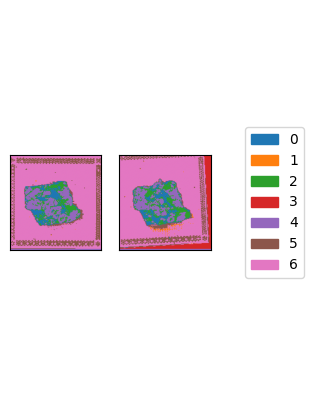

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

he 1


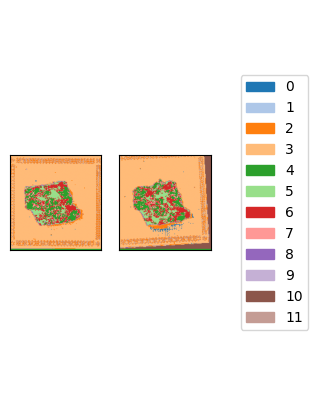

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned


he 2


INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closing glyph list over 'MATH': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 

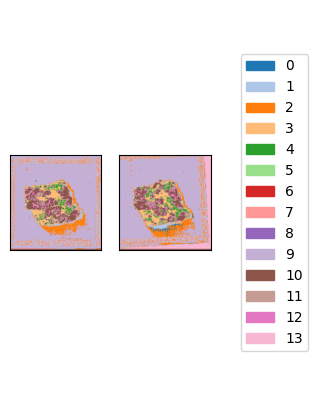

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 12 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 12 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26]
INFO:fontTools.subset:Closing g

multiplex 0


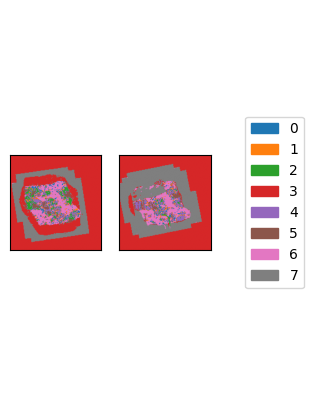

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

multiplex 1


INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned


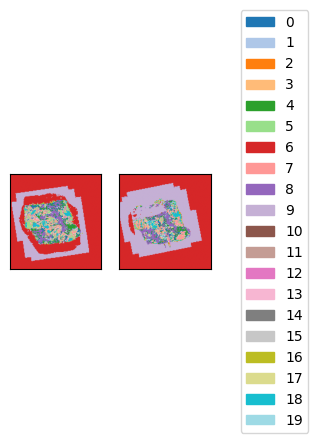

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

multiplex 2


INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned


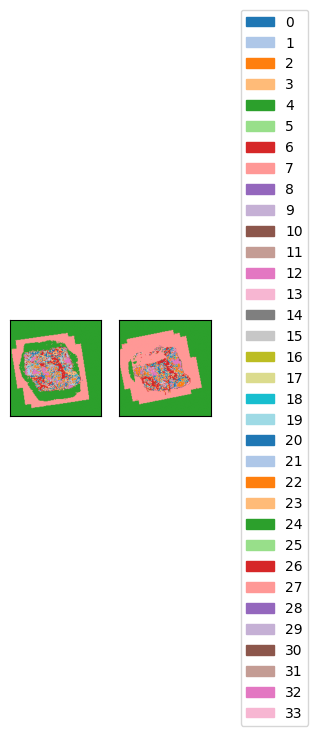

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 11 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 11 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'five', 'four', 'nonmarkingreturn', 'one', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25]
INFO:fontTools.subset:Closing glyph list over 'MATH': 11 

visium 0


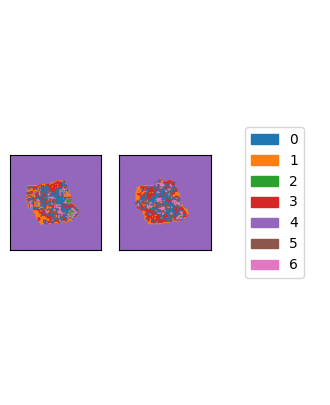

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

visium 1


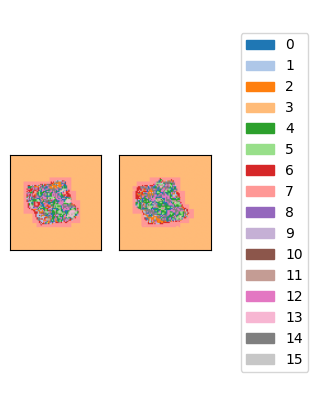

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

visium 2


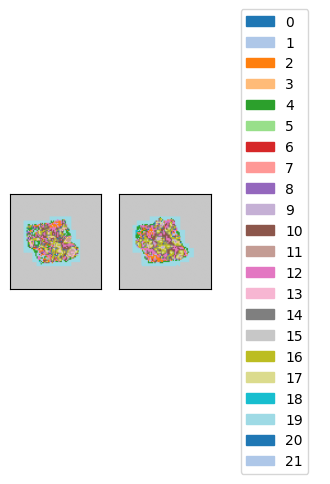

In [18]:
for dtype in mushroom.dtypes:
    for level in range(mushroom.num_levels):
        print(dtype, level)
        mushroom.display_clusters(dtype, level=level)
        plt.savefig(os.path.join(fig_dir, f'nbhds_{dtype}_l{level}.pdf'), dpi=300)
        plt.show()

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for visium spore


0


INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 45796 edges
INFO:root:2166 edges remaining after filtering
INFO:root:214 of 214 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 6 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'p', 'r', 's', 'space', 't', 'u', 'v', 'x']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 68, 71, 72, 74, 75, 76, 79, 80, 81, 83, 85, 86, 87, 88

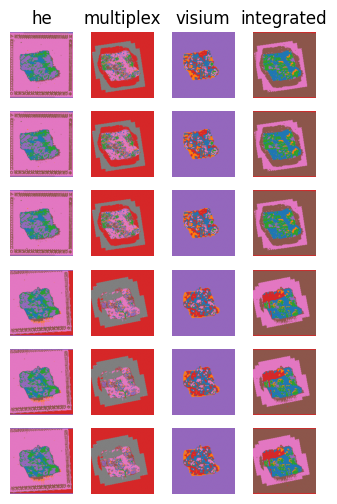

INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore


1


INFO:root:generating volume for visium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 842724 edges
INFO:root:32704 edges remaining after filtering
INFO:root:918 of 918 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 10 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'p', 'r', 's', 'space', 't', 'u', 'v', 'x']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 68, 71

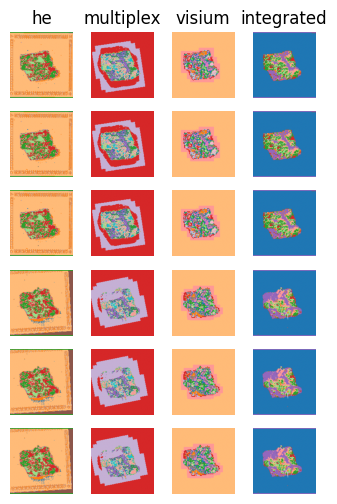

INFO:root:generating volume for he spore


2


INFO:root:generating volume for multiplex spore
INFO:root:generating volume for visium spore
INFO:root:generating integrated volume
INFO:root:merging cluster volumes
INFO:root:constructing graph with 2143296 edges
INFO:root:78294 edges remaining after filtering
INFO:root:1464 of 1464 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 14 clusters
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'd', 'e', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'p', 'r', 's', 'space', 't', 'u', 'v', 'x']
INF

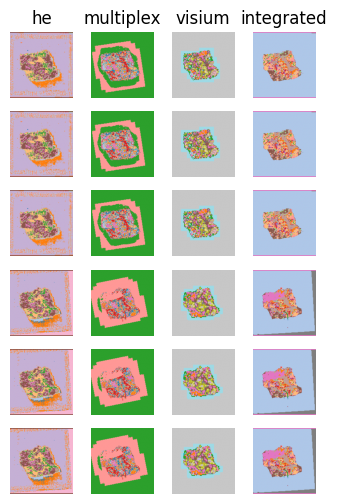

In [19]:
for level, cluster_res in enumerate(cluster_resolutions):
    print(level)
    dtype_to_volume = mushroom.generate_interpolated_volumes(
        z_scaler=z_scaler, level=level, integrate=True, dtype_to_weight=dtype_to_weight, resolution=cluster_res)
    dtype_to_volume_labels = {k:v.argmax(-1) if k != 'integrated' else v for k, v in dtype_to_volume.items()}
    
    mushroom.display_volumes(dtype_to_volume=dtype_to_volume_labels, positions=mushroom.section_positions)
    
    plt.savefig(os.path.join(fig_dir, f'nbhd_volumes_l{level}.pdf'), dpi=300)
    plt.show()
    
    np.save(os.path.join(out_dir, f'nbhd_volumes_l{level}.npy'), {
        'probs': dtype_to_volume,
        'labeled': dtype_to_volume_labels
    })
    
    del(dtype_to_volume)
    del(dtype_to_volume_labels)

In [20]:
fig_dir

'/data/estorrs/sandbox/HT397B1_2000step/figures'

In [21]:
mushroom.save()

INFO:root:saving config and outputs to /data/estorrs/sandbox/HT397B1_2000step


In [22]:
clustering_params = {
    'z_scaler': z_scaler,
    'cluster_resolutions': cluster_resolutions,
    'dtype_to_weight': dtype_to_weight
}
yaml.safe_dump(clustering_params, open(os.path.join(out_dir, 'nbhd_volume_params.yaml'), 'w'))

In [22]:
# new = Mushroom.from_config('/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom')


In [23]:
# mushroom.display_clusters('he', level=0)